# Fundamental diagrams

The nonlinearities inherent in traffic flow are captured by the so-called [fundamental diagrams](https://en.wikipedia.org/wiki/Fundamental_diagram_of_traffic_flow#/media/File:Fundamental_Diagram.PNG). Try to re-make the fundamental diagrams from our data.

In [1]:
using CSV
using DataFrames
using Statistics
using KFactors
using KFactors.FundamentalDiagrams
using Plots
using RawArray
using CategoricalArrays
using Printf
using RollingFunctions
using StatsBase
using Distributions

┌ Info: Precompiling KFactors [ed362b46-60d5-416f-85cf-bff05ff5e122]
└ @ Base loading.jl:1664

(process:19024): GLib-GIO-WARNING **: 13:09:30.350: Unexpectedly, UWP app `Microsoft.ScreenSketch_11.2302.20.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.ScreenSketch_8wekyb3d8bbwe!App') supports 29 extensions but has no verbs


In [2]:
# Generated by fundamental_diagrams.jl
data_raw = raread("../data/fundamental_diagram.ra");

In [3]:
# define human-readable names for axes
const SPEED = 1
const FLOW = 2
const DENS = 3
const OCC = 4

4

In [4]:
# not plotting axis 4 occupancy as not part of normal fundamental diagrams
data = dropdims(sum(data_raw, dims=OCC), dims=OCC);

In [5]:
# insert commas in numbers
# https://stackoverflow.com/questions/52213829
function commas(num::Integer)
    str = string(num)
    return replace(str, r"(?<=[0-9])(?=(?:[0-9]{3})+(?![0-9]))" => ",")
end

commas (generic function with 1 method)

In [6]:
sampsize = sum(data)

3400538286

In [27]:
speed_flow = resample(dropdims(sum(data, dims=DENS), dims=DENS), (1, 2))
# Do this as a map from speed to flow due to nonmonotonicity
speed_flow_y, speed_flow_x = getlines(transpose(speed_flow))

speed_flow = toquantiles(speed_flow, 30, skipzero=true);

In [36]:
speed_density = resample(dropdims(sum(data, dims=FLOW), dims=FLOW), (3, 2))
# smooth less aggresively at start to avoid averaging in many lower values
speed_density_x, speed_density_y = getlines(speed_density)
speed_density = toquantiles(speed_density, 30, skipzero=true);

In [52]:
dens_flow = resample(dropdims(sum(data, dims=SPEED), dims=SPEED), (2, 2))
# smooth not very much early on, so we don't average in too many higher values when we don't
# have lower values in the average
# expand the window and smooth more aggressively as we get to sparser data
# https://xkcd.com/2048/
dens_flow_x, dens_flow_y = getlines(dens_flow; scale=[fill(1, 50)..., fill(5, 82)...])
dens_flow = toquantiles(dens_flow, 30, skipzero=true);

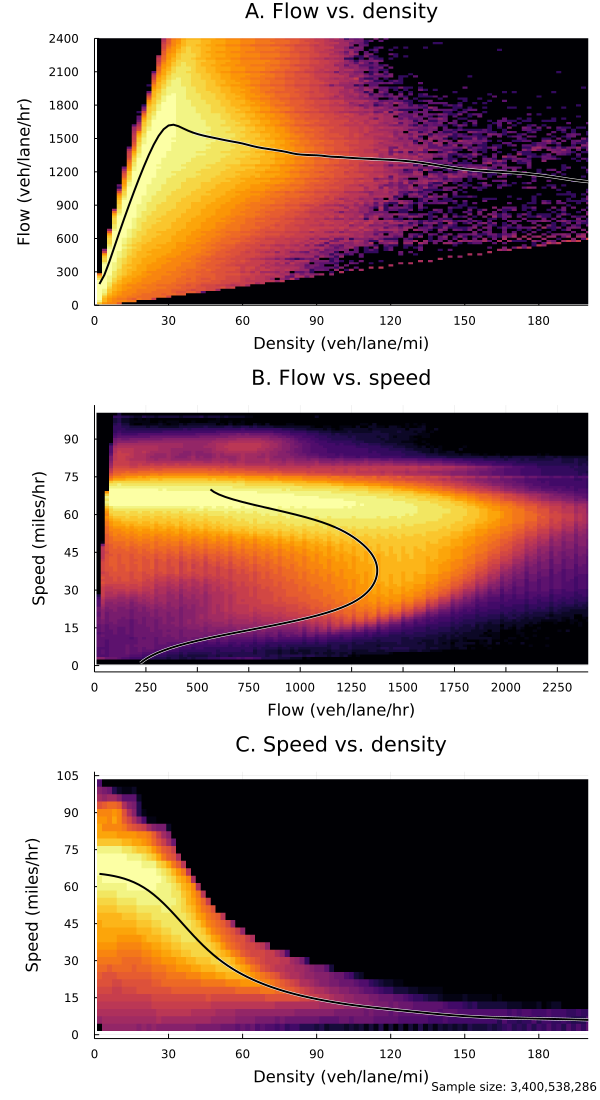

In [53]:
speed_flow_plot = heatmap(speed_flow, yticks=0:15:100, xticks=(0:25//2:115, (0:250:2250)), legend=false)
plot!(speed_flow_x[1:55], speed_flow_y[1:55], color="white", linewidth=3)
plot!(speed_flow_x[1:70], speed_flow_y[1:70], color="black", linewidth=2)
xlims!(speed_flow_plot, 0, 2400 / 20)
ylabel!(speed_flow_plot, "Speed (miles/hr)")
xlabel!(speed_flow_plot, "Flow (veh/lane/hr)")
title!(speed_flow_plot, "B. Flow vs. speed")

speed_dens_plot = heatmap(speed_density, yticks=(0:5:35, (0:5:35) .* 3), xticks=(0:15:90, (0:15:90) .* 2), legend=false)
plot!(speed_density_x[25:end], speed_density_y[25:end], color="white", linewidth=3)
plot!(speed_density_x, speed_density_y, color="black", linewidth=2)
xlabel!(speed_dens_plot, "Density (veh/lane/mi)")
ylabel!(speed_dens_plot, "Speed (miles/hr)")
xlims!(0, 100)
annotate!(speed_dens_plot, 85, -7, text("Sample size: $(commas(sampsize))", pointsize=8))
title!(speed_dens_plot, "C. Speed vs. density")

dens_flow_plot = heatmap(dens_flow, yticks=(0:15:120, (0:15:120) .* 20), xticks=(0:15:90, (0:15:90) .* 2), legend=false)
plot!(dens_flow_x[20:end], dens_flow_y[20:end], color="white", linewidth=3)
plot!(dens_flow_x, dens_flow_y, color="black", linewidth=2)
xlabel!(dens_flow_plot, "Density (veh/lane/mi)")
ylims!(0, 2400/20)
xlims!(0, 100)
ylabel!(dens_flow_plot, "Flow (veh/lane/hr)")
title!(dens_flow_plot, "A. Flow vs. density")

plot(dens_flow_plot, speed_flow_plot, speed_dens_plot, layout=grid(3, 1), size=(600, 1100), left_margin=10Plots.mm)
savefig("../fig/fundamental_diagrams.pdf")
plot!()


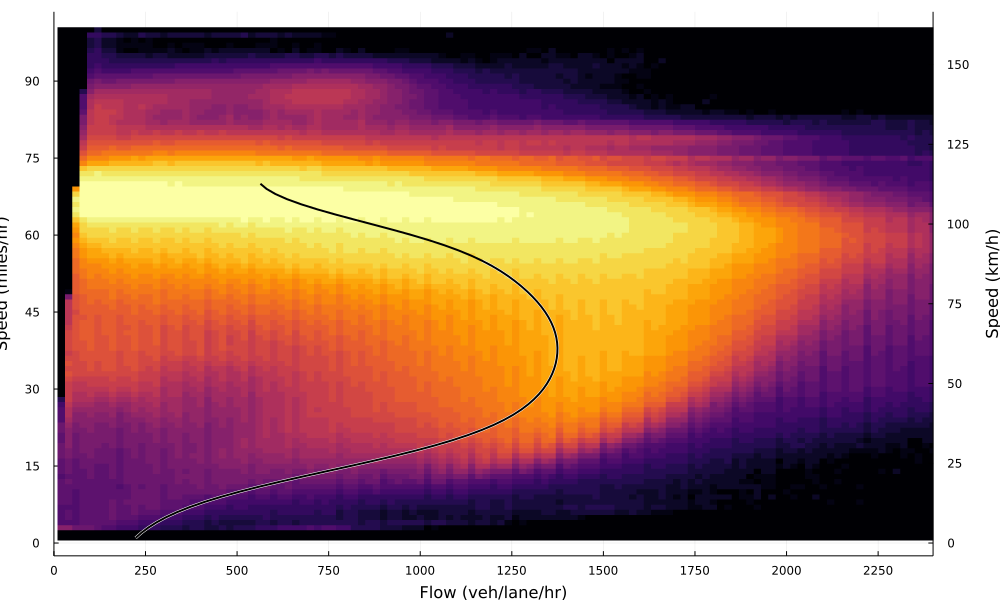

In [51]:
plot(speed_flow_plot, right_margin=15Plots.mm, dpi=300, size=(1000, 600))
title!("")
annotate!(102, -14, text("Sample size: $(commas(sampsize))", pointsize=8))
ax2 = twinx()
plot!(ax2, xticks=false)
ylabel!(ax2, "Speed (km/h)")
yticks!(ax2, 0:25:150)
ylims!(ax2, ylims() .* 1.609)
savefig("../fig/speed_flow_ic2s2.png")
plot!()